### Závěrečný projekt - modul Python

V tomto projektu budete analyzovat data ze stránky `www.sreality.cz`. Budete tedy získávat aktuální nabídku bytů ve Zlíně.
Projekt se dělí na 2 části:
1. WebScraping - pomocí knihovny `BeautifulSoup` získejte všechny aktuální inzerce bytů v daném městě. 
- Získáte **tyto** informace: `URL odkaz bytu, rozměry bytu, kompozice bytu, cena bytu, lokace bytu (Ulice+město)`
2. Datová analýza - ETL proces
- V první fázi prověďte processing dat tak, aby obsahovala příslušné datové typy, nenulové hodnoty atp. Ulice i město bude v samostatných sloupcích.
- Zprocesovaná a vyčištěná data vyexportujte do `.csv` souboru s názvem `{vašeJméno}_zdrojová_data.csv`
3. Datová analýza - analýza dat
- Třetí část začněte tak, že si do dataframe nahrajete vámi vyexportovaný `.csv` soubor s vyscrapovanými daty.
- Ve druhé fázi proveďte analýzu dat a odpovězte na tyto dotazy:
- `Jaká je průměrná cena bytů?`
- `Jaká je průměrná cena bytů pro každou kompozici (1+1, 2+1, atp.)? Zobrazte i na grafu.`
- `Jaká je průměrná velikost bytu pro každou kompozici?`
- `Existuje ulice, kde je vyšší koncentrace dražších bytů?`
- `Jaký typ kompozice je v daném městě nejčastěji inzerovan? Který to je? Proč myslíte, že tomu tak je?`
- `Existují zde inzerce bytů, které stojí více, než 20.000,-? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
- `Zjištěte minimální a maximální inzerce pro každou kompozici bytu. Která kompozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?`


Dotazy zodpovězte ve vašem pracovním notebooku a výsledný soubor nahrajte na GitHub.


### WebScraping

In [ ]:
from bs4 import BeautifulSoup
import requests

strana = 1


inzeraty = []

while True:
    mesto = 'zlin'
    data = requests.get(f'https://www.sreality.cz/hledani/pronajem/byty/{mesto}?strana={strana}').text
    soup = BeautifulSoup(data, 'html.parser')

    """
    ------------------------
    Zde pište svůj kód 
    ------------------------
    """
    #### Vypiš URL adresu každého inzerátu
    # najde všechny inzeráty na stránce
    list_inzeratu = soup.findAll("li", class_= "MuiGrid-root MuiGrid-item css-l1328q")

    # vyloučit inzerát na makléře - třídu má stejnou jako inzerát pronájmu (jiné reklamy mají jinou, tj. už se vyloučily výše)
    
    for inzerat in list_inzeratu:
        # Zbavuju se reklamy na makléře - má v ID slovo "broker"
        inzerat_id = inzerat.get("id")
        if "broker" in inzerat_id:
            continue
        else:
            #### Získají se URL adresy inzerátů
            odkaz_tag = inzerat.find("a")["href"]
            link = "https://www.sreality.cz/" + odkaz_tag
            
        
            #### Vypiš informace ke každému inzerátu (dispozice, cena, lokace)
            ## Dispozice - upravim to až v rámci pandas na dvě proměnné
            dispozice = (inzerat.find("div", class_="MuiBox-root css-n6y9a7")
                        .find("p", class_="MuiTypography-root MuiTypography-body1 css-13ztabn")
                        .text.replace("Pronájem bytu ",""))
        

            ## Cena
            cena_temp = inzerat.find("div", class_="MuiBox-root css-n6y9a7").find("p", class_="MuiTypography-root MuiTypography-body1 css-1ndcg2e").text
            cista_cena = cena_temp.replace("\xa0","").replace("Kč/měsíc","")
            

            ## Lokace bytu (Ulice+Město)
            # do dvou sloupců rozdělím v pandas
            lokace = (inzerat.find("div", class_="MuiBox-root css-n6y9a7")
                            .findAll("p", class_="MuiTypography-root MuiTypography-body1 css-13ztabn")[1].text)
            

            ## SPojení vyscrapovaných informací do slovníku
            objekt_inzerat = {
                "URL": link,
                "Dispozice a rozměr": dispozice,
                "Cena [Kč/měsíc]": cista_cena,
                "Lokace": lokace
                }
            inzeraty.append(objekt_inzerat)
    

    """
    ------------------------------------------------------------------------------------------------
    Tohle ponechte pod vaším kódem - kontroluje se, zda na stránce existuje tlačítko Další stránky. Pokud ne, program končí.
    ------------------------------------------------------------------------------------------------
    """
    
    button = soup.find('button', 'MuiButtonBase-root MuiButton-root MuiButton-outlined MuiButton-outlinedInherit MuiButton-sizeMedium MuiButton-outlinedSizeMedium MuiButton-colorInherit MuiButton-root MuiButton-outlined MuiButton-outlinedInherit MuiButton-sizeMedium MuiButton-outlinedSizeMedium MuiButton-colorInherit css-lp5ywq').text

    if button != 'Další stránka':
        print('Již zde není žádná další strana. Končím')
        break

    strana += 1

    print(f'Scrapuju stránku č. {strana}')





### Datová analýza - ETL process

In [ ]:
import pandas as pd
df = pd.DataFrame(inzeraty)

df.info()

In [94]:
# ULOŽ DATA DO CSV
df.to_csv('Valentova_Data_scraping.csv', index=False)


In [130]:
# Nahraj data z csv
df = pd.read_csv("Valentova_Data_scraping.csv")

In [131]:
# Rozdělení sloupce "Dispozice a rozměr" na dvě proměnné ("Dispozice" a "Rozměr")
df["Dispozice"] = df["Dispozice a rozměr"].str.split().str[0]
df["Rozměr [m2]"] = df["Dispozice a rozměr"].str.split().str[1]

# Rozdělení sloupce "Lokace" na "Ulici" a "Město"
df["Ulice"] = df["Lokace"].str.split(",").str[0]
df["Město"] = df["Lokace"].str.split(",").str[1]
df.head()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   URL                 153 non-null    object
 1   Dispozice a rozměr  153 non-null    object
 2   Cena [Kč/měsíc]     153 non-null    object
 3   Lokace              153 non-null    object
 4   Dispozice           153 non-null    object
 5   Rozměr [m2]         153 non-null    object
 6   Ulice               153 non-null    object
 7   Město               139 non-null    object
dtypes: object(8)
memory usage: 9.7+ KB


In [133]:
# některé inzeráty nemají vyplněné město - tam je město v názvu ulice (resp. tedy nemají ulici)
# Tam, kde je Město nan --> Vyplň Město hodnotou z "Ulice"
df.loc[df["Město"].isna(), "Město"] = df.loc[df["Město"].isna(), "Ulice"]
df["Město"].unique()
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   URL                 153 non-null    object
 1   Dispozice a rozměr  153 non-null    object
 2   Cena [Kč/měsíc]     153 non-null    object
 3   Lokace              153 non-null    object
 4   Dispozice           153 non-null    object
 5   Rozměr [m2]         153 non-null    object
 6   Ulice               153 non-null    object
 7   Město               153 non-null    object
dtypes: object(8)
memory usage: 9.7+ KB


In [134]:
df.head()

## -------------------Úprava datových typů 
# Ve sloupci cena jsou 4 inzeráty s "Cena na vyžádání". Tyto hodnoty pomocí filtrace odstraním přepsáním celého df
df = df.loc[df["Cena [Kč/měsíc]"] != "Cena na vyžádání"]

# Změna Ceny na integer
df["Cena [Kč/měsíc]"] = df["Cena [Kč/měsíc]"].astype(int)

# Změna Rozměru na integer
# Ve sloupci Rozměr je jeden výskyt 1+kk, tak ten řádek odstraním
df = df.loc[df["Rozměr [m2]"] != "1+kk"]

df["Rozměr [m2]"] = df["Rozměr [m2]"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 0 to 152
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   URL                 148 non-null    object
 1   Dispozice a rozměr  148 non-null    object
 2   Cena [Kč/měsíc]     148 non-null    int32 
 3   Lokace              148 non-null    object
 4   Dispozice           148 non-null    object
 5   Rozměr [m2]         148 non-null    int32 
 6   Ulice               148 non-null    object
 7   Město               148 non-null    object
dtypes: int32(2), object(6)
memory usage: 9.2+ KB


In [135]:
# Do CSV
df.to_csv("Valentova_zdrojova_data_k_analyze.csv")

In [136]:
# Nahrání z .csv
df = pd.read_csv("Valentova_zdrojova_data_k_analyze.csv", index_col=0)

### 3. Datová analýza
- `Jaká je průměrná cena bytů?`
- `Jaká je průměrná cena bytů pro každou kompozici (1+1, 2+1, atp.)? Zobrazte i na grafu.`
- `Jaká je průměrná velikost bytu pro každou kompozici?`
- `Existuje ulice, kde je vyšší koncentrace dražších bytů?`
- `Jaký typ kompozice je v daném městě nejčastěji inzerovan? Který to je? Proč myslíte, že tomu tak je?`
- `Existují zde inzerce bytů, které stojí více, než 20.000,-? Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
- `Zjištěte minimální a maximální inzerce pro každou kompozici bytu. Která kompozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?`

In [201]:
df.head()
df.info()
# Průměrná cena bytů?
prumerna_cena_bytu = df["Cena [Kč/měsíc]"].mean()

median_ceny_bytu = df["Cena [Kč/měsíc]"].median()

print(f"Průměrná cena bytů je {prumerna_cena_bytu:.2f} Kč")
print(f"Mediánová cena bytů je {median_ceny_bytu} Kč.")

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 0 to 152
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   URL                 148 non-null    object
 1   Dispozice a rozměr  148 non-null    object
 2   Cena [Kč/měsíc]     148 non-null    int64 
 3   Lokace              148 non-null    object
 4   Dispozice           148 non-null    object
 5   Rozměr [m2]         148 non-null    int64 
 6   Ulice               148 non-null    object
 7   Město               148 non-null    object
dtypes: int64(2), object(6)
memory usage: 10.4+ KB
Průměrná cena bytů je 14133.70 Kč
Mediánová cena bytů je 13500.0 Kč.


In [138]:
# Jaká je průměrná cena bytů pro každou kompozici (1+1, 2+1, atp.)? Zobrazte i na grafu.
dispozice_cena = df.groupby("Dispozice")["Cena [Kč/měsíc]"].mean().reset_index(name="Průměrná cena")
dispozice_cena




,Dispozice,Průměrná cena
0,1+1,10228.571429
1,1+kk,11200.000000
2,2+1,13351.666667
3,2+kk,16531.052632
4,3+1,16832.500000
5,3+kk,19125.000000
6,4+1,20000.000000
7,4+kk,39900.000000
8,atypický,9750.000000
9,pokoje,6889.777778


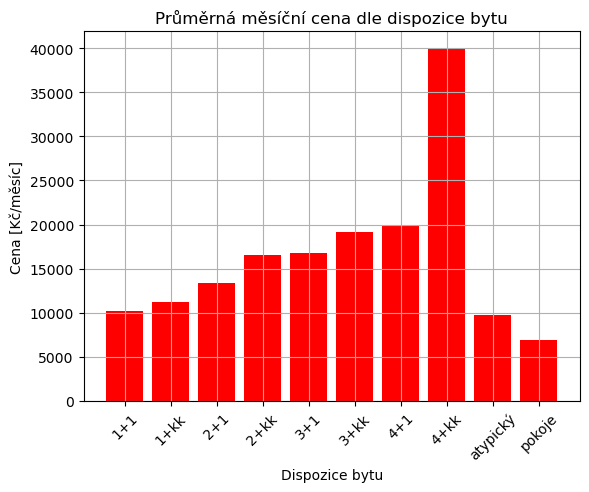

In [139]:
import matplotlib.pyplot as plt
plt.bar(dispozice_cena["Dispozice"], dispozice_cena["Průměrná cena"], color="red")
plt.title("Průměrná měsíční cena dle dispozice bytu")
plt.xlabel("Dispozice bytu")
plt.ylabel("Cena [Kč/měsíc]")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [140]:
df.head()

,URL,Dispozice a rozměr,Cena [Kč/měsíc],Lokace,Dispozice,Rozměr [m2],Ulice,Město
0,https://www.sreality.cz//detail/pronajem/byt/3...,3+1 73 m²,19000,"Slezská, Zlín",3+1,73,Slezská,Zlín
1,https://www.sreality.cz//detail/pronajem/byt/1...,1+kk 26 m²,8300,"Tečovská, Zlín - Malenovice",1+kk,26,Tečovská,Zlín - Malenovice
3,https://www.sreality.cz//detail/pronajem/byt/2...,2+kk 65 m²,18700,"Lorencova, Zlín",2+kk,65,Lorencova,Zlín
4,https://www.sreality.cz//detail/pronajem/byt/2...,2+1 56 m²,12000,"Dlouhá, Zlín",2+1,56,Dlouhá,Zlín
5,https://www.sreality.cz//detail/pronajem/byt/1...,1+1 25 m²,9000,"Vysoká, Zlín",1+1,25,Vysoká,Zlín


In [141]:
## `Jaká je průměrná velikost bytu pro každou kompozici?`
dispozice_rozmer = df.groupby("Dispozice")["Rozměr [m2]"].mean().reset_index(name="Průměrný rozměr")
dispozice_rozmer

,Dispozice,Průměrný rozměr
0,1+1,35.071429
1,1+kk,29.125000
2,2+1,56.166667
3,2+kk,58.815789
4,3+1,77.750000
5,3+kk,82.875000
6,4+1,81.000000
7,4+kk,100.000000
8,atypický,27.000000
9,pokoje,37.666667


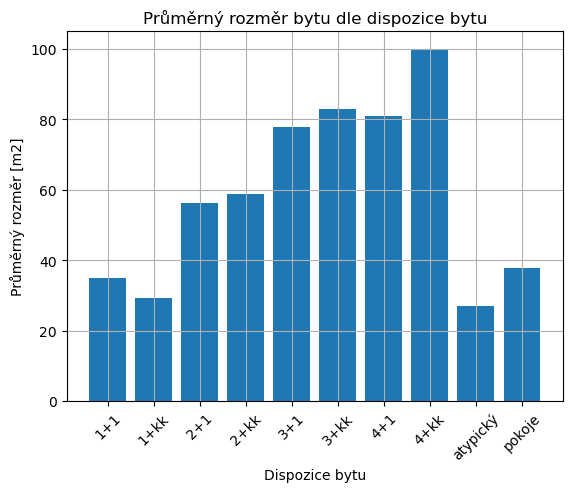

In [144]:
plt.bar(dispozice_rozmer["Dispozice"], dispozice_rozmer["Průměrný rozměr"])
plt.title("Průměrný rozměr bytu dle dispozice bytu")
plt.xlabel("Dispozice bytu")
plt.ylabel("Průměrný rozměr [m2]")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [145]:
df.head()

,URL,Dispozice a rozměr,Cena [Kč/měsíc],Lokace,Dispozice,Rozměr [m2],Ulice,Město
0,https://www.sreality.cz//detail/pronajem/byt/3...,3+1 73 m²,19000,"Slezská, Zlín",3+1,73,Slezská,Zlín
1,https://www.sreality.cz//detail/pronajem/byt/1...,1+kk 26 m²,8300,"Tečovská, Zlín - Malenovice",1+kk,26,Tečovská,Zlín - Malenovice
3,https://www.sreality.cz//detail/pronajem/byt/2...,2+kk 65 m²,18700,"Lorencova, Zlín",2+kk,65,Lorencova,Zlín
4,https://www.sreality.cz//detail/pronajem/byt/2...,2+1 56 m²,12000,"Dlouhá, Zlín",2+1,56,Dlouhá,Zlín
5,https://www.sreality.cz//detail/pronajem/byt/1...,1+1 25 m²,9000,"Vysoká, Zlín",1+1,25,Vysoká,Zlín


In [174]:
# `Existuje ulice, kde je vyšší koncentrace dražších bytů?`
# podle ulic si rozdělím soubor - vypočítají se mi k němu agregační fce k sloupci Cena
ulice_agg = df.groupby("Ulice")["Cena [Kč/měsíc]"].agg(["mean","median","count","max"]).reset_index()
ulice_agg
# Vypíšu si ulice, kde je průměrná cena vyšší než průměrná cena všech bytů
drazsi_ulice = ulice_agg.loc[ulice_agg["mean"] > prumerna_cena_bytu].sort_values(by="mean", ascending=False)
# vyber drazsich ulic - tam, kde je víc než jeden byt (aby se dalo hovořit o "vyšší koncentraci" dražších bytů)
drazsi_ulice.loc[drazsi_ulice["count"] > 1]



,Ulice,mean,median,count,max
23,Lešetín I,20500.000000,20500.0,2,25000
26,Luhačovice,19980.000000,15000.0,5,39900
54,Smetanova,19175.000000,19350.0,4,25000
52,Slezská,19000.000000,19000.0,5,19000
4,Chelčického,17450.000000,17450.0,2,19000
53,Slunečná,16750.000000,16750.0,2,21000
69,Zelinova,16400.000000,16400.0,2,17900
37,Nádražní,16300.000000,16300.0,2,23000
35,Nivy II,16250.000000,16250.0,2,16500
41,Pasecká,16200.000000,17200.0,3,17900


In [180]:
# `Jaký typ kompozice je v daném městě nejčastěji inzerovan? Který to je? Proč myslíte, že tomu tak je?`
df.head()
dispozice_pocet = df.groupby("Dispozice")["Dispozice"].count().reset_index(name="Počet bytů")
dispozice_pocet

,Dispozice,Počet bytů
0,1+1,14
1,1+kk,24
2,2+1,30
3,2+kk,38
4,3+1,20
5,3+kk,8
6,4+1,2
7,4+kk,1
8,atypický,2
9,pokoje,9


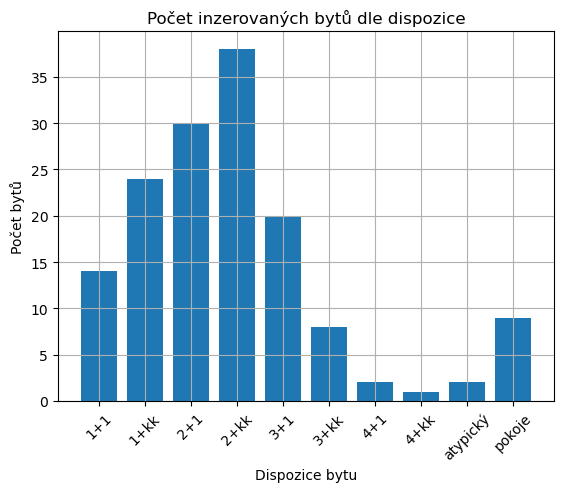

In [182]:
plt.bar(dispozice_pocet["Dispozice"], dispozice_pocet["Počet bytů"])
plt.title("Počet inzerovaných bytů dle dispozice")
plt.xlabel("Dispozice bytu")
plt.ylabel("Počet bytů")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [190]:
# Existují zde inzerce bytů, které stojí více, než 20.000,-? 
# Pokud ano, jsou v této cenové hladině inzerovány i maximálně dvoupokojové byty (2+1/2+kk)?`
df.head()
byty_nad_20tis = df.loc[df["Cena [Kč/měsíc]"] > 20000]
byty_nad_20tis.groupby("Dispozice")["Cena [Kč/měsíc]"].count()
#byty_nad_20tis

Dispozice
2+kk    5
3+kk    2
4+1     1
4+kk    1
Name: Cena [Kč/měsíc], dtype: int64

In [198]:
# `Zjištěte minimální a maximální inzerce pro každou kompozici bytu. 
# Která kompozice má největší rozptyl mezi minimální a maximální inzerovanou cenou?`
df.head()
dispozice_min_max = df.groupby("Dispozice")["Cena [Kč/měsíc]"].agg(["min","max"]).reset_index()
dispozice_min_max["Rozdil"] = dispozice_min_max["max"] - dispozice_min_max["min"]
dispozice_min_max.sort_values(by="Rozdil", ascending=False)

,Dispozice,min,max,Rozdil
3,2+kk,9000,25000,16000
5,3+kk,13000,29000,16000
0,1+1,4200,13500,9300
1,1+kk,6500,14900,8400
2,2+1,9000,16500,7500
4,3+1,11900,19000,7100
9,pokoje,3708,10500,6792
8,atypický,7500,12000,4500
6,4+1,19000,21000,2000
7,4+kk,39900,39900,0
